# Configuration & Tools

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 24 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

## Import modules

In [1]:
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch as T
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Set random seed

I set seed=0 its works better than 777 but 777 is also work

In [2]:

if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [3]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.max_size = max_size
        self.mem_cntr = 0
        self.states_buffer = np.zeros((self.max_size, *input_shape))
        self.new_state_buffer = np.zeros((self.max_size, *input_shape))
        self.action_buffer = np.zeros((self.max_size, n_actions))
        self.reward_buffer = np.zeros(self.max_size)
        self.terminal_buffer = np.zeros(self.max_size, dtype=np.float32)

    def store_transition(self, state, action, reward, new_state, done):
        ptbr = self.mem_cntr % self.max_size
        self.states_buffer[ptbr] = state
        self.new_state_buffer[ptbr] = new_state
        self.action_buffer[ptbr] = action
        self.reward_buffer[ptbr] = reward
        self.terminal_buffer[ptbr] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.max_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.states_buffer[batch]
        actions = self.action_buffer[batch]
        rewards = self.reward_buffer[batch]
        states_ = self.new_state_buffer[batch]
        terminal = self.terminal_buffer[batch]

        return states, actions, rewards, states_, terminal

In [4]:
class ReplayBuffer(object):
    def __init__(self, obs_dim: int, size: int, batch_size):
        self.max_size = size
        self.memory_counter = 0
        self.states_buffer = np.zeros((self.max_size, *obs_dim))
        self.new_state_buffer = np.zeros((self.max_size, *obs_dim))
        self.action_buffer = np.zeros((self.max_size, 1))
        self.reward_buffer = np.zeros(self.max_size)
        self.terminal_buffer = np.zeros(self.max_size, dtype=np.float32)

    def store_transition(self, state, action, reward, new_state, done):
        ptbr = self.memory_counter % self.max_size
        self.states_buffer[ptbr] = state
        self.new_state_buffer[ptbr] = new_state
        self.action_buffer[ptbr] = action
        self.reward_buffer[ptbr] = reward
        self.terminal_buffer[ptbr] = 1 - done
        self.memory_counter += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.memory_counter, self.max_size)

        batch = np.random.choice(max_mem, batch_size)

        return dict(
            states=self.states_buffer[batch],
            actions=self.action_buffer[batch],
            rewards=self.reward_buffer[batch],
            new_state=self.new_state_buffer[batch],
            terminal=self.terminal_buffer[batch]
        )


## OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

# PPO

- PPO: [J. Schulman et al., "Proximal Policy Optimization Algorithms." arXiv preprint arXiv:1707.06347, 2017.](https://arxiv.org/abs/1707.06347.pdf)
- TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. 2015.](http://proceedings.mlr.press/v37/schulman15.pdf)

There are two kinds of algorithms of PPO: PPO-Penalty and PPO-Clip. Here, we'll implement PPO-clip version.

TRPO computes the gradients with a complex second-order method. On the other hand, PPO tries to solve the problem with a first-order methods that keep new policies close to old. To simplify the surrogate objective, let $r(\theta)$ denote the probability ratio

$$ L^{CPI}(\theta) = \hat {\mathbb{E}}_t \left [ {\pi_\theta(a_t|s_t) \over \pi_{\theta_{old}}(a_t|s_t)} \hat A_t\right] = \hat {\mathbb{E}}_t \left [ r_t(\theta) \hat A_t \right ].$$

The objective is penalized further away from $r_t(\theta)$

$$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

If the advantage is positive, the objective will increase. As a result, the action becomes more likely. If advantage is negative, the objective will decrease. AS a result, the action becomes less likely.

# DDPG 

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

# Networks


## PPO Networks

We will use two separated networks for actor and critic respectively. The actor network consists of two fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Gaussian distribution. Pendulum-v0 has only one action which has a range from -2 to 2. In order to fit the range, the actor outputs the mean value with tanh. The result will be scaled in ActionNormalizer class. On the one hand, the critic network has three fully connected layers as two hidden layers (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed.

I use the multinormal in the ppo agent and just return the mean of the distribution


In [6]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3):
    torch.nn.init.uniform_(layer.weight.data, -init_w, init_w)
    torch.nn.init.uniform_(layer.bias.data, -init_w, init_w)


class PPOActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        log_std_min: int = -20,
        log_std_max: int = 0,
    ):
        """Initialize."""
        super(PPOActor, self).__init__()
        self.out = nn.Sequential(
                nn.Linear(in_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, out_dim),
                nn.Tanh()
            )



    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.out(state)




class PPOCritic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(PPOCritic, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )



    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.out(state)


## DDPG Networks
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [7]:
class DDPGActor(nn.Module):
    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            init_w: float = 3e-3,
    ):
        """Initialize."""
        super(DDPGActor, self).__init__()
        self.in_dim = in_dim
        self.first_layer_number = 128
        self.second_layer_number = 64
        self.first_layer = nn.Linear(*self.in_dim, self.first_layer_number)
        w1 = 1. / np.sqrt(self.first_layer.weight.data.size()[0])
        init_layer_uniform(self.first_layer, w1)
        self.batch_norm_1 = nn.LayerNorm(self.first_layer_number)

        self.second_layer = nn.Linear(self.first_layer_number, self.second_layer_number)
        w2 = 1. / np.sqrt(self.second_layer.weight.data.size()[0])
        init_layer_uniform(self.second_layer, w2)
        self.batch_norm_2 = nn.LayerNorm(self.second_layer_number)
        self.result = nn.Linear(self.second_layer_number, 1)
        init_layer_uniform(self.result)

    def forward(self, state):
        x = self.first_layer(state)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        x = self.second_layer(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = torch.tanh(self.result(x))

        return x


class DDPGCritic(nn.Module):
    def __init__(
            self,
            in_dim: int,
            init_w: float = 3e-3,
    ):
        super(DDPGCritic, self).__init__()
        self.in_dim = in_dim
        self.first_layer_size = 400
        self.second_layer_size = 300
        self.first_layer = nn.Linear(*self.in_dim, 400)
        w1 = 1. / np.sqrt(self.first_layer.weight.data.size()[0])
        init_layer_uniform(self.first_layer, w1)
        self.batch_norm_1 = nn.LayerNorm(400)
        self.second_layer = nn.Linear(400, 300)
        w2 = 1. / np.sqrt(self.second_layer.weight.data.size()[0])
        init_layer_uniform(self.second_layer, w2)
        self.batch_norm_2 = nn.LayerNorm(self.second_layer_size)
        self.action_value = nn.Linear(1, self.second_layer_size)
        self.q = nn.Linear(self.second_layer_size, 1)
        init_layer_uniform(self.q)

    def forward(self, state, action):
        state_value = self.first_layer(state)
        state_value = self.batch_norm_1(state_value)
        state_value = F.relu(state_value)
        state_value = self.second_layer(state_value)
        state_value = self.batch_norm_2(state_value)

        Q_value = F.relu(self.action_value(action))
        V_S_a = F.relu(torch.add(state_value, Q_value))
        V_S_a = self.q(V_S_a)
        return V_S_a

# Agents 

## PPO Agent
Here is a summary of PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|_plot             | plot the training progresses.                        |


PPO updates the model several times(`epoch`) using the stacked memory. By `ppo_iter` function, It yield the samples of stacked memory by interacting a environment.

In [8]:
class PPOIterBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


In [9]:
from torch.distributions import MultivariateNormal
import math

In [10]:
scores_ppo = []
actor_loss_ppo=[]
critic_loss_ppo=[]
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
            self,
            env: gym.Env,
            batch_size: int,
            gamma: float,
            tau: float,
            epsilon: float,
            epoch: int,
            rollout_len: int,
            entropy_weight: float,
    ):
        self.env = env
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.rollout_len = rollout_len
        self.gamma = gamma
        self.action_dim = 1
        self.PPOItrator = PPOIterBuffer()
        self.epoch = epoch
        self.std_rate = 0.02
        self.update_std_nums =int(2.5e5)
        self.action_std = math.exp(0)
        self.action_std = 1.0
        self.min_action_std = math.exp(-20)
        self.epochs = epoch
        self.eps_clip = epsilon
        self.entropy_weight = entropy_weight  # learning rate for critic network
        self.action_var = torch.full((1,), self.action_std * self.action_std).to(self.device)
        self.MseLoss = nn.MSELoss()
        self.actor_old = PPOActor(in_dim=3, out_dim=1).to(self.device)
        self.actor_new = PPOActor(in_dim=3, out_dim=1).to(self.device)
        self.critic_old = PPOCritic(in_dim=3).to(self.device)
        self.critic_new = PPOCritic(in_dim=3).to(self.device)
        self.optimizer = torch.optim.Adam([
            {'params': self.actor_new.parameters(), 'lr': 0.0003},
            {'params': self.critic_new.parameters(), 'lr': 0.001}
        ])
        self.actor_old.load_state_dict(self.actor_new.state_dict())
        self.critic_old.load_state_dict(self.critic_new.state_dict())
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            state = torch.FloatTensor(state).to(self.device)
            action_mean = self.actor_old(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
            action = dist.sample()
            action_logprob = dist.log_prob(action)
            state_val = self.critic_old(state)
            action, action_logprob, state_val = action.detach(), action_logprob.detach(), state_val.detach()
        self.PPOItrator.states.append(state)
        self.PPOItrator.actions.append(action)
        self.PPOItrator.logprobs.append(action_logprob)
        self.PPOItrator.state_values.append(state_val)

        return action.detach().cpu().numpy().flatten()



    def update_model(
            self, next_state: np.ndarray
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        global scores_ppo 
        global actor_loss_ppo
        global critic_loss_ppo
        rewards = []
        final_reward = 0
        device = self.device
        for reward, is_terminal in zip(reversed(self.PPOItrator.rewards), reversed(self.PPOItrator.is_terminals)):
            if is_terminal:
                final_reward = 0
            final_reward = reward + (self.gamma * final_reward)
            rewards.insert(0, final_reward)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        states_old = torch.squeeze(torch.stack(self.PPOItrator.states, dim=0)).detach().to(device)
        action_old = torch.squeeze(torch.stack(self.PPOItrator.actions, dim=0)).detach().to(device)
        logp_old = torch.squeeze(torch.stack(self.PPOItrator.logprobs, dim=0)).detach().to(device)
        Vs_old = torch.squeeze(torch.stack(self.PPOItrator.state_values, dim=0)).detach().to(device)
        advantages = rewards.detach() - Vs_old.detach()
        for _ in range(self.epochs):
            action_mean = self.actor_new(states_old)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            if self.action_dim == 1:
                action_old = action_old.reshape(-1, self.action_dim)
            action_logprobs = dist.log_prob(action_old)
            dist_entropy = dist.entropy()
            state_values = self.critic_new(states_old)
            logprobs, state_values, dist_entropy = action_logprobs, state_values, dist_entropy
            state_values = torch.squeeze(state_values)
            ratios = torch.exp(logprobs - logp_old.detach())

            result1 = ratios * advantages
            result2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            serg_loss = -torch.min(result1, result2)

            loss = -torch.min(result1, result2) + 0.5 * self.MseLoss(state_values, rewards) - self.entropy_weight * dist_entropy
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            actor_loss_ppo.append(self.MseLoss(state_values, rewards))
            critic_loss_ppo.append(serg_loss)


        self.actor_old.load_state_dict(self.actor_new.state_dict())
        self.critic_old.load_state_dict(self.critic_new.state_dict())
        self.PPOItrator.clear()

    def train(self, num_frames: int, plotting_interval: int = 200):
        global scores_ppo
        print_running_reward = 0
        print_running_episodes = 0

        log_running_reward = 0
        log_running_episodes = 0
        time_step = 0
        i_episode = 0
        while time_step <= num_frames:
            state = self.env.reset()
            current_ep_reward = 0
            print_freq = self.rollout_len * 10
            log_freq = self.rollout_len * 2
            update_time_step = self.rollout_len * 4
            for t in range(1, self.rollout_len + 1):
                action = self.select_action(state)
                state, reward, done, _ = env.step(action)
                self.PPOItrator.rewards.append(reward)
                self.PPOItrator.is_terminals.append(done)

                time_step += 1
                current_ep_reward += reward
                if time_step % update_time_step == 0:
                    self.update_model(state)
                if time_step % self.update_std_nums == 0:
                    self.action_std = self.action_std - self.std_rate
                    self.action_std = round(self.action_std, 4)
                    if (self.action_std <= self.min_action_std):
                        self.action_std = self.min_action_std
                    self.action_var = torch.full((1,), self.action_std * self.action_std).to(self.device)

                if time_step % print_freq == 0:
                    
                    print_avg_reward = print_running_reward / print_running_episodes
                    print_avg_reward = round(print_avg_reward, 2)
                    scores_ppo.append(print_avg_reward)

                    print("Episode : {} Reward : {}".format(i_episode, print_avg_reward))

                    print_running_reward = 0
                    print_running_episodes = 0
                if done:
                    break

            print_running_reward += current_ep_reward
            print_running_episodes += 1

            log_running_reward += current_ep_reward
            log_running_episodes += 1

            i_episode += 1

        

    def test(self):
      self.is_test = True  
      env = self.env  
      state = env.reset()  
      done = False 

      frames = []  
      total_reward = 0  
      while not done:
          action = self.select_action(state)  # select an action
          next_state, reward, done, _ = env.step(action)  # take the action in the environment
          total_reward += reward  # increment total reward
          state = next_state  
          frames.append(env.render(mode="rgb_array"))
      return frames


    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        # ==================================== Your Code (Begin) ====================================
        # 1. define a function for sub plots
        # 2. for each variable plot the specific subplot
        # 3. plot the whole figure
        # ==================================== Your Code (End) ====================================


## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [11]:
class DDPGAgent:
    def __init__(
            self,
            env: gym.Env,
            memory_size,
            batch_size,
            gamma,
            tau,
            initial_random_steps,
    ):
        self.gamma = gamma
        self.tau = tau
        input_dims = [3]
        self.memory_size = memory_size
        self.memory = ReplayBuffer(batch_size=batch_size, size=memory_size, obs_dim=input_dims)
        self.batch_size = batch_size
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.actor = DDPGActor(in_dim=input_dims,out_dim=1).to(device=self.device)
        self.critic = DDPGCritic(in_dim=input_dims).to(device=self.device)
        self.target_actor = DDPGActor(in_dim=input_dims,out_dim=1).to(device=self.device)
        self.target_critic = DDPGCritic(in_dim=input_dims).to(device=self.device)
        beta = 0.00025
        alpha = 0.000025
        self.target_entropy = -torch.prod(torch.Tensor(env.action_space.shape)).item()
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha = self.log_alpha.exp()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=beta)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=alpha)

        self.noise = OUNoise(1)
        self.total_step = 0
        self.ra = initial_random_steps

        self._target_soft_update(tau=1)
        self.env = env
        self.is_test = False

    def choose_action(self, observation, ):
        if self.total_step < self.ra:
            mu_prime = self.env.action_space.sample()
            self.total_step += 1
            return mu_prime

        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(self.device)
        mu = self.actor.forward(observation).to(self.device)
        if self.is_test:
          mu_prime = mu
        else:
          mu_prime = mu + T.tensor(self.noise.sample(),
                                 dtype=T.float).to(self.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()

        """Select an action from the input state."""

        # ==================================== Your Code (Begin) ====================================
        # 1. check if initial random action should be conducted
        # 2. add noise for exploration during training
        # 3. store transition
        # return selected action
        # ==================================== Your Code (End) ====================================

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        # I dont use this function beacuse I cant store state in replay buffer I write this function in train
        return None

    def update_model(self) -> torch.Tensor:
        if self.memory.memory_counter < self.batch_size:
            return 0,0
        batch = self.memory.sample_buffer(self.batch_size)
        reward = T.tensor(batch['rewards'], dtype=T.float).to(self.device)
        terminal = T.tensor(batch['terminal']).to(self.device)
        new_state = T.tensor(batch['new_state'], dtype=T.float).to(self.device)
        action = T.tensor(batch['actions'], dtype=T.float).to(self.device)
        state = T.tensor(batch['states'], dtype=T.float).to(self.device)
        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)
        target = [reward[j] + self.gamma * critic_value_[j] * terminal[j] for j in range(self.batch_size)]
        target = T.tensor(target).to(self.device)
        target = target.view(self.batch_size, 1)
        self.critic.train()
        self.critic_optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic.eval()
        self.actor_optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor_optimizer.step()
        self._target_soft_update()
        return critic_loss.item(), actor_loss.item()
        """Update the model by gradient descent."""


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def train(self, num_frames: int, plotting_interval: int = 100):

        epoch = int(num_frames/200)
        score_history = []
        policy_loss = []
        actor_loss = []
        for i in range(epoch):
            obs = env.reset()
            done = False
            score = 0
            while not done:

                act = self.choose_action(obs)
                new_state, reward, done, info = env.step(act)
                self.remember(obs, act, reward, new_state, int(done))
                x,y = self.update_model()

                policy_loss.append(x)
                actor_loss.append(y)
                score += reward
                obs = new_state
            score_history.append(score)
            if i%20==0:
              print('episode ', i, 'meaning score %.3f' % np.mean(score_history[-plotting_interval:]))
        i=0
        while policy_loss[i]==0:
          policy_loss = policy_loss[i+1:]
          actor_loss = actor_loss[i+1:]
        policy_loss = [ x*-1 for x in policy_loss]
        actor_loss = [ x*-1 for x in actor_loss]

        self._plot(i,score_history , policy_loss ,actor_loss )

    def test(self):
        self.is_test = True
        env = self.env
        state = env.reset()
        done = False
        frames = []
        total_reward = 0
        while not done:
            action = self.choose_action(state)  # select an action
            next_state, reward, done, _ = env.step(action)  # take the action in the environment
            total_reward += reward  # increment total reward
            state = next_state
            frames.append(env.render(mode="rgb_array"))
        return frames

    def _target_soft_update(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)
        


    def _plot(
            self,
            frame_idx: int,
            scores: List[float],
            actor_losses: List[float],
            critic_losses: List[float],
    ):
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title("scores")
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
          running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(running_avg)
        plt.subplot(132)
        plt.title("actor loss")
        running_avg = np.zeros(len(actor_losses))
        for i in range(len(running_avg)):
          running_avg[i] = np.mean(actor_losses[max(0, i-500):(i+1)])

        plt.plot(running_avg)
        plt.subplot(133)
        plt.title("critic loss")
        running_avg = np.zeros(len(critic_losses))
        for i in range(len(running_avg)):
          running_avg[i] = np.mean(critic_losses[max(0, i-500):(i+1)])
        plt.plot(running_avg)
        plt.show()
      

# Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [12]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        rescaled_action = ((action + 1) / 2) * (self.action_space.high - self.action_space.low) + self.action_space.low
        return rescaled_action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        reversed_action = (2 * (action - self.action_space.low) / (self.action_space.high - self.action_space.low)) - 1
        return reversed_action


You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v1 from OpenAI's repository.

In [13]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[0]

# Train & Test 

## Initialize

لطفا یکبار دیگر با این پارامتر ها ترین شود  در اخرین ران انجام شده به علت مشکل سیستم تعداد فریم ها پنجاه هزار عدد ست شد در صورتی که اگر 150000 ست شود امتیاز به حدود منفی 300 می رسد

In [14]:
# parameters
num_frames = 150000
memory_size = 20000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

ppo_agent = PPOAgent(
    env,
    gamma = 0.99,
    tau = 0.8,
    batch_size = 64,
    epsilon = 0.2,
    epoch = 80,
    rollout_len = 1000 ,
    entropy_weight = 0.01
)
ppo_agent.train(num_frames)

Episode : 49 Reward : -1159.47
Episode : 99 Reward : -1146.83
Episode : 149 Reward : -1007.03
Episode : 199 Reward : -958.05
Episode : 249 Reward : -888.4


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


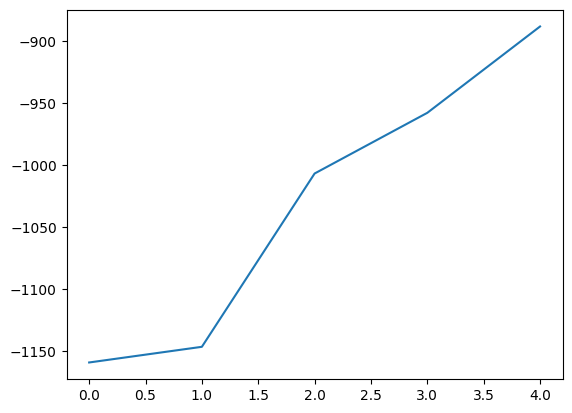

In [15]:
plt.plot(scores_ppo)

In [41]:
def plotLearning(scores):
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title("loss")
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
          running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(running_avg)
        plt.show()


In [42]:
x = [i.detach().numpy() for i in actor_loss_ppo]


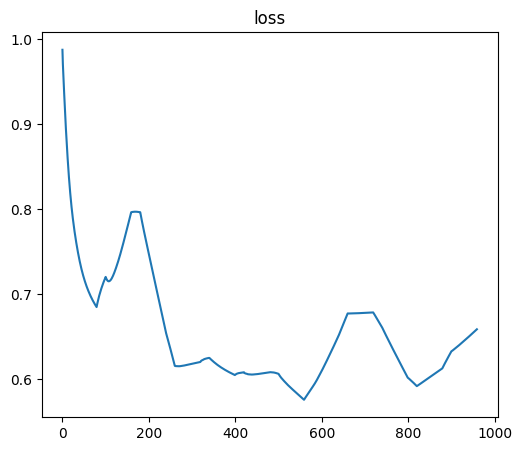

In [43]:
plotLearning(x)

## Train PPO

In [18]:
frames = ppo_agent.test()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Train DDPG

In [74]:
initial_random_steps =100
import copy

ddpg_agent = DDPGAgent(
   env=env,initial_random_steps=100,
            memory_size=1000000,
            batch_size = 64,
            gamma = 0.99,
            tau = 0.001
)

episode  0 meaning score -1026.030
episode  20 meaning score -1297.041
episode  40 meaning score -1146.802
episode  60 meaning score -1038.280
episode  80 meaning score -980.687
episode  100 meaning score -919.363
episode  120 meaning score -789.503
episode  140 meaning score -704.238
episode  160 meaning score -658.058
episode  180 meaning score -610.121
episode  200 meaning score -595.561
episode  220 meaning score -599.774
episode  240 meaning score -627.746


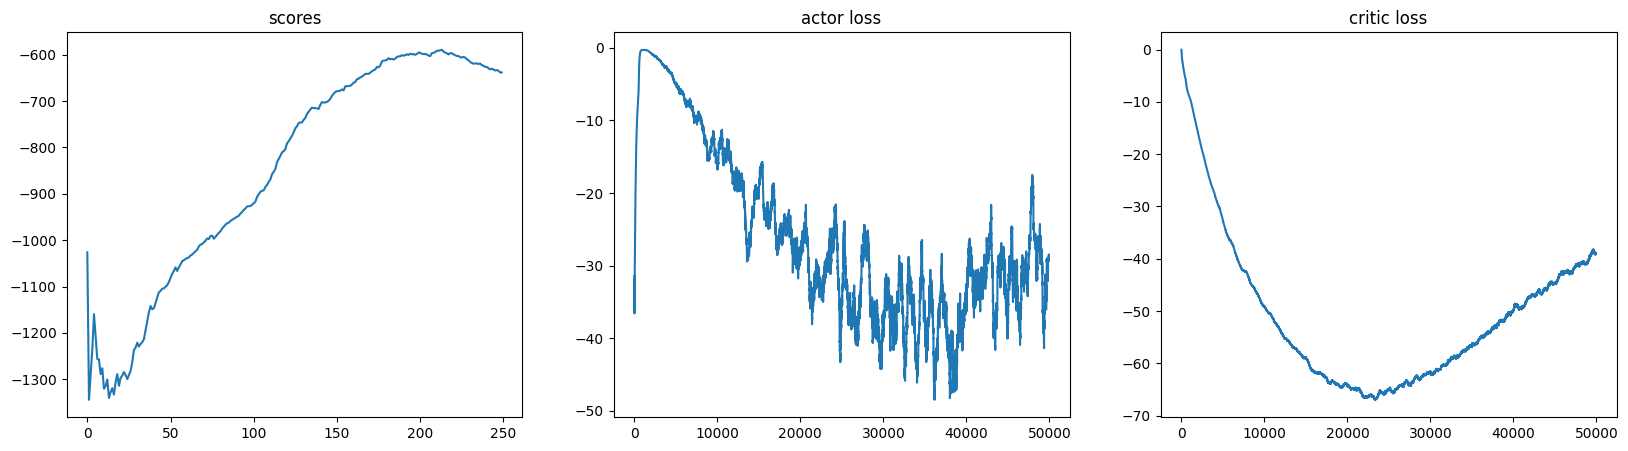

In [75]:
ddpg_agent.train(50000)

In [78]:
frames_ddpg = ddpg_agent.test()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [32]:
frames_ppo = ppo_agent.test()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



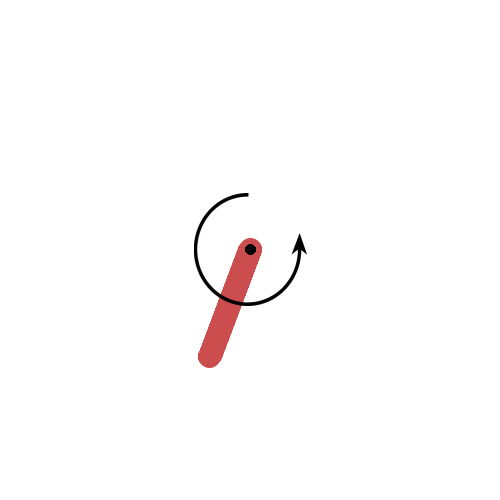

In [24]:
import imageio
from IPython.display import HTML
import base64
# assuming frames is a list of image frames
with imageio.get_writer('animation.gif', mode='I') as writer:
    for frame in frames_ddpg:
        writer.append_data(frame)

# display the animation
with open('animation.gif', 'rb') as file:
    display(HTML('<img src="data:image/gif;base64,{}" />'.format(base64.b64encode(file.read()).decode())))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



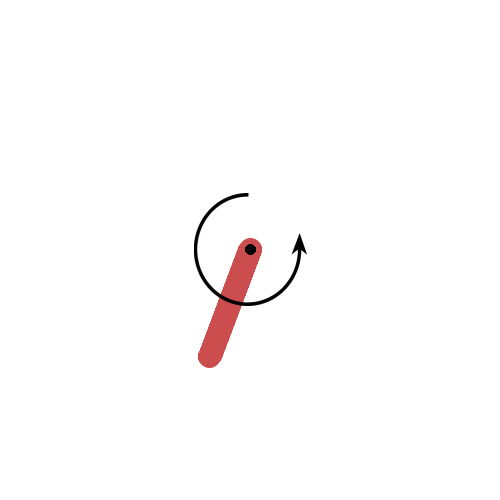

In [40]:
import imageio
from IPython.display import HTML
import base64
# assuming frames is a list of image frames
with imageio.get_writer('animation.gif', mode='I') as writer:
    for frame in frames_ppo:
        writer.append_data(frame)

# display the animation
with open('animation.gif', 'rb') as file:
    display(HTML('<img src="data:image/gif;base64,{}" />'.format(base64.b64encode(file.read()).decode())))

## Test

In [22]:
# test
if IN_COLAB:
    ppo_agent.env = gym.wrappers.Monitor(ppo_agent.env, "videos", force=True)
    # ddpg_agent.env = gym.wrappers.Monitor(ddpg_agent.env, "videos", force=True)
ppo_frames = ppo_agent.test()
# ddpg_frames = ddpg_agent.test()

AttributeError: ignored

## Render

In [23]:
if IN_COLAB:  # for colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display

    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)

else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames):
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display 
    display_frames_as_gif(frames)
    # display_frames_as_gif(ddpg_frames)

ValueError: ignored